In [4]:
# Import necessary libraries
import pyodbc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

In [5]:
server = 'DESKTOP-I83O72A'
database = 'SAP'

conn = pyodbc.connect(
    f'DRIVER={{ODBC Driver 17 for SQL Server}};'
    f'SERVER={server};'
    f'DATABASE={database};'
    'Trusted_Connection=yes'
)

# 4. Importation des données
query = "SELECT * FROM [SAP].[dbo].[Dim_Suppliers_finale]"
df_suppliers = pd.read_sql(query, conn)
# Vérification rapide
print("Premières lignes du dataset :")
display(df_suppliers.head())

Premières lignes du dataset :


C:\Users\Admin\AppData\Local\Temp\ipykernel_13456\2094208980.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_suppliers = pd.read_sql(query, conn)


,PK_Supplier,ID_Supplier,Supplier_Name,Environmental_Certifications,Sustainability_Program,Transport_Type
0,48706,1,Laiterie Centrale,Agriculture Biologique,Oui,Unknown
1,40782,2,Agro-Alimentaire Tunisie,Aucune,Non,Unknown
2,30344,3,Import-Export Naturel,ISO 14001,Non,Unknown
3,48042,4,QualitÚ Fra¯cheur,Aucune,Non,Unknown
4,34563,5,Fruits et Saveurs,Aucune,Oui,Unknown


In [5]:
print(df_suppliers.head())

   PK_Supplier  ID_Supplier             Supplier_Name  \
0        48706            1         Laiterie Centrale   
1        40782            2  Agro-Alimentaire Tunisie   
2        30344            3     Import-Export Naturel   
3        48042            4         QualitÚ Fra¯cheur   
4        34563            5         Fruits et Saveurs   

  Environmental_Certifications Sustainability_Program Transport_Type  
0       Agriculture Biologique                    Oui        Unknown  
1                       Aucune                    Non        Unknown  
2                    ISO 14001                    Non        Unknown  
3                       Aucune                    Non        Unknown  
4                       Aucune                    Oui        Unknown  


In [6]:
print(df_suppliers.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166 entries, 0 to 165
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   PK_Supplier                   166 non-null    int64 
 1   ID_Supplier                   166 non-null    int64 
 2   Supplier_Name                 166 non-null    object
 3   Environmental_Certifications  166 non-null    object
 4   Sustainability_Program        166 non-null    object
 5   Transport_Type                166 non-null    object
dtypes: int64(2), object(4)
memory usage: 7.9+ KB
None


In [6]:
# Importations supplémentaires
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

df_suppliers = df_suppliers.drop(columns=['PK_Supplier', 'ID_Supplier', 'Supplier_Name'])

# Séparation des variables numériques et catégorielles
cat_cols = ['Environmental_Certifications', 'Sustainability_Program', 'Transport_Type']
num_cols = []  # Aucune dans ce dataset

# Création du pipeline de prétraitement
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ],
    remainder='passthrough'
)

# Application du prétraitement
df_processed = preprocessor.fit_transform(df_suppliers)

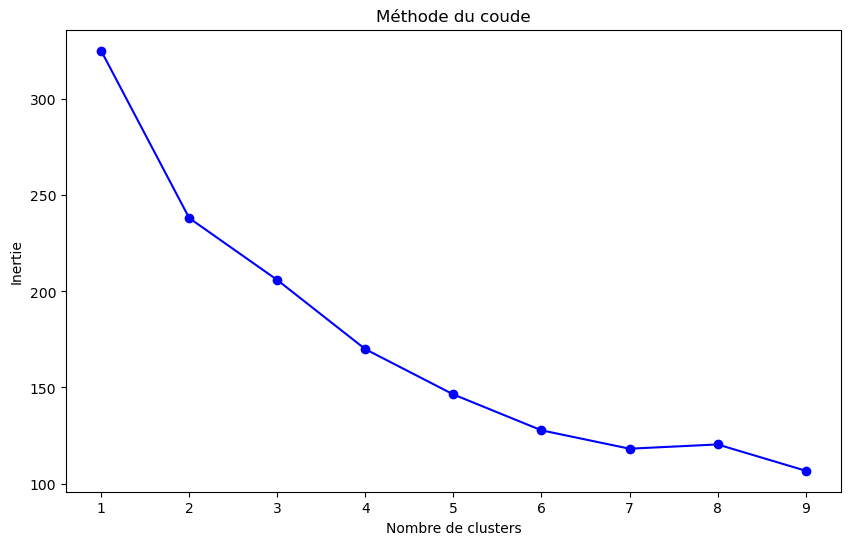

In [7]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Méthode du coude pour déterminer le nombre optimal de clusters
inertia = []
K_range = range(1, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_processed)
    inertia.append(kmeans.inertia_)

# Visualisation
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.title('Méthode du coude')
plt.show()

In [9]:
from sklearn.metrics import silhouette_score
import pandas as pd

# 1. Appliquer KMeans avec le nombre optimal de clusters (par exemple 3)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(df_processed)

# 2. Calcul du score de silhouette
# D'abord, nous devons nous assurer que df_processed est un DataFrame pandas
if not isinstance(df_processed, pd.DataFrame):
    # Si c'est une matrice sparse, la convertir en DataFrame
    # Nous utilisons les noms de colonnes du transformateur (si disponible)
    try:
        feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out()
        df_processed = pd.DataFrame(df_processed.toarray(), columns=feature_names)
    except:
        # Si nous ne pouvons pas obtenir les noms de caractéristiques, utilisons des noms génériques
        df_processed = pd.DataFrame(df_processed.toarray(), columns=[f'feature_{i}' for i in range(df_processed.shape[1])])

# Calcul du score de silhouette
silhouette_avg = silhouette_score(df_processed, clusters)
print(f"Score de silhouette moyen: {silhouette_avg:.3f}")

# 3. Ajout des clusters au DataFrame original pour analyse
df_suppliers['Cluster'] = clusters

# Analyse descriptive des clusters
def analyze_clusters(df, cluster_col, cat_cols):
    analysis = {}

    # Pour chaque cluster
    for cluster in sorted(df[cluster_col].unique()):
        cluster_data = df[df[cluster_col] == cluster]
        cluster_info = {}

        # Analyse des variables catégorielles
        for col in cat_cols:
            counts = cluster_data[col].value_counts(normalize=True)
            cluster_info[col] = {
                'top_category': counts.idxmax(),
                'top_percentage': round(counts.max() * 100, 1),
                'categories_distribution': counts.to_dict()
            }

        analysis[f'Cluster {cluster}'] = {
            'size': len(cluster_data),
            'characteristics': cluster_info
        }

    return analysis

# Analyse des clusters
cluster_analysis = analyze_clusters(df_suppliers, 'Cluster', cat_cols)

# Affichage des résultats
for cluster, info in cluster_analysis.items():
    print(f"\n{cluster} (taille: {info['size']} fournisseurs)")
    for col, col_info in info['characteristics'].items():
        print(f"  {col}:")
        print(f"    Catégorie dominante: {col_info['top_category']} ({col_info['top_percentage']}%)")
        print("    Distribution complète:")
        for cat, perc in col_info['categories_distribution'].items():
            print(f"      - {cat}: {round(perc*100, 1)}%")

Score de silhouette moyen: 0.258

Cluster 0 (taille: 70 fournisseurs)
  Environmental_Certifications:
    Catégorie dominante: Agriculture Biologique (60.0%)
    Distribution complète:
      - Agriculture Biologique: 60.0%
      - ISO 14001: 40.0%
  Sustainability_Program:
    Catégorie dominante: Oui (100.0%)
    Distribution complète:
      - Oui: 100.0%
  Transport_Type:
    Catégorie dominante: Unknown (34.3%)
    Distribution complète:
      - Unknown: 34.3%
      - Multimodal: 20.0%
      - Maritime: 20.0%
      - Ferroviaire: 17.1%
      - AÚrien: 5.7%
      - Camionnage: 2.9%

Cluster 1 (taille: 70 fournisseurs)
  Environmental_Certifications:
    Catégorie dominante: Aucune (40.0%)
    Distribution complète:
      - Aucune: 40.0%
      - ISO 14001: 40.0%
      - Agriculture Biologique: 20.0%
  Sustainability_Program:
    Catégorie dominante: Non (100.0%)
    Distribution complète:
      - Non: 100.0%
  Transport_Type:
    Catégorie dominante: Ferroviaire (28.6%)
    Distributi